In [166]:
import pandas as pd
import os
import numpy as np
import datetime

In [83]:
# Get the path of the notebook file
notebook_path = os.path.abspath('__file__')

# Directory containing the notebook file
notebook_directory = os.path.dirname(notebook_path)

In [84]:
train_events = pd.read_csv(notebook_directory+"/Data/train_events.csv")

In [85]:
#droping the night where we don't have infomation about sleep
#train_events.dropna(subset=["step"],inplace=True)

In [86]:
# Convert the 'date_column' to datetime
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], format='%Y-%m-%dT%H:%M:%S%z')

In [87]:
# Create the datetime object
dt = train_events.timestamp[0]

# Calculate the total number of seconds for the time portion
seconds_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

# Calculate the number of seconds for the timezone offset
tz_offset_seconds = -14400  # Offset of -4 hours, converted to seconds

# Add the two values together
total_seconds_passed = seconds_since_midnight + tz_offset_seconds

print(total_seconds_passed)

66360.0


In [88]:
# Extract the time and create a new column with just the time
#train_events['only_time'] = train_events['timestamp'].apply(lambda x: x.time())

## Finding min onset time and max wakeup time

In [89]:
# onset_train_events = train_events[train_events["event"] == "onset"]
# min_onset_time = min(onset_train_events[onset_train_events["only_time"]>datetime.time(12,0)]["only_time"])

In [90]:
# wakeup_train_events = train_events[train_events["event"] == "wakeup"]
# max_wakeup_time = max(wakeup_train_events[wakeup_train_events["only_time"]<datetime.time(12,0)]["only_time"])

In [91]:
# min_onset_time,max_wakeup_time

In [92]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00-04:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00-04:00
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06 04:07:00-04:00
14504,fe90110788d2,34,onset,574620.0,2017-09-06 23:35:00-04:00
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07 09:17:00-04:00
14506,fe90110788d2,35,onset,NaN,NaN


## Labelling whether in a particular step that person is sleeping or not

In [111]:
train_events[train_events["night"] == 0+1][(train_events[train_events["night"] == 0+1])["event"] == "onset"]["step"].iloc[0]

4992.0

In [141]:
max_night = max(train_events["night"].tolist())
max_step = max(train_events["step"].tolist())
max_night,max_step

(84, 739392.0)

In [187]:
label_event = {}

for id in train_events.series_id.unique().tolist():
    night = 0
    step = 0
    train_event_fil_id = train_events[train_events["series_id"] == id]
    df_activity = pd.DataFrame()
    activity_list = []
    sure = True

    while night < max_night and step < max_step: 
       
        train_events_fil_id_night = train_event_fil_id[train_event_fil_id["night"] == night+1]
        
        if len(train_events_fil_id_night) != 0:# checking whether or not we have any night information for that day
            step_onset = train_events_fil_id_night[train_events_fil_id_night["event"] == "onset"]["step"].iloc[0]
            step_wakeup = train_events_fil_id_night[train_events_fil_id_night["event"] == "wakeup"]["step"].iloc[0]
            if sure:
                if  not np.isnan(step_onset) and not np.isnan(step_wakeup):
                    activity_list += ["active"]*int(step_onset-step-1)
                    activity_list.append("onset")
                    activity_list += ["sleep"]*int(step_wakeup-step_onset-1)
                    activity_list.append("wakeup")
                    step = step_wakeup
                    sure = True
                    night +=1
                else:
                    night += 1
                    sure = False
            else:
                if  not np.isnan(step_onset) and not np.isnan(step_wakeup):
                    activity_list += ["unknown"]*int(step_onset-step-1)
                    activity_list.append("onset")
                    activity_list += ["sleep"]*int(step_wakeup-step_onset-1)
                    activity_list.append("wakeup")
                    step = step_wakeup
                    sure = True
                    night +=1
                else:
                    night += 1
                    sure = False

            step_wakeup = train_events_fil_id_night[train_events_fil_id_night["event"] == "wakeup"]["step"].iloc[0]


        else:
            night += 1
    df_activity["activity"] = activity_list
    label_event[id] = df_activity

In [193]:
label_event

{'038441c925bb':        activity
 0        active
 1        active
 2        active
 3        active
 4        active
 ...         ...
 369907    sleep
 369908    sleep
 369909    sleep
 369910    sleep
 369911   wakeup
 
 [369912 rows x 1 columns],
 '03d92c9f6f8a':        activity
 0        active
 1        active
 2        active
 3        active
 4        active
 ...         ...
 255055    sleep
 255056    sleep
 255057    sleep
 255058    sleep
 255059   wakeup
 
 [255060 rows x 1 columns],
 '0402a003dae9':        activity
 0        active
 1        active
 2        active
 3        active
 4        active
 ...         ...
 376915    sleep
 376916    sleep
 376917    sleep
 376918    sleep
 376919   wakeup
 
 [376920 rows x 1 columns],
 '04f547b8017d':        activity
 0       unknown
 1       unknown
 2       unknown
 3       unknown
 4       unknown
 ...         ...
 446395    sleep
 446396    sleep
 446397    sleep
 446398    sleep
 446399   wakeup
 
 [446400 rows x 1 columns],


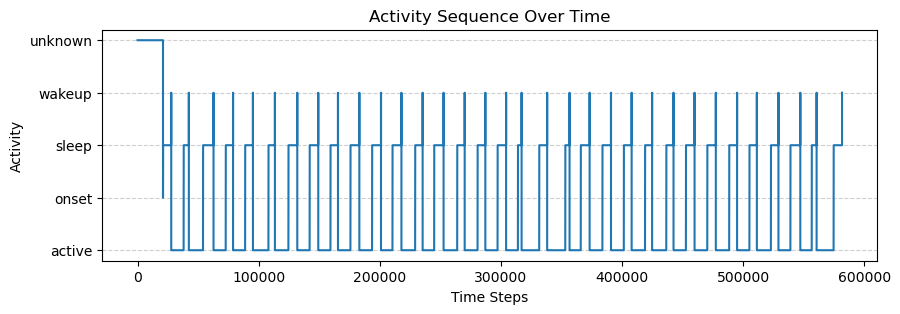

In [189]:
import matplotlib.pyplot as plt

# Sample list of activities
activities = ["active", "onset", "sleep", "wakeup", "unknown"]

# Create a list of integers to represent the activities (e.g., mapping each activity to a number)
activity_mapping = {
    "active": 0,
    "onset": 1,
    "sleep": 2,
    "wakeup": 3,
    "unknown": 4,
}

# List representing the sequence of activities
activity_sequence = activity_list

# Map the activities to their corresponding integers
activity_sequence_mapped = [activity_mapping[activity] for activity in activity_sequence]

# Create a plot
plt.figure(figsize=(10, 3))
plt.plot(activity_sequence_mapped)
plt.title("Activity Sequence Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Activity")
plt.yticks(range(len(activities)), activities)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.show()
